## The Binomial Pricing Model and the Binomial Paths Averaging Method

When we have a stochastic model, we simulate an appropriate number of paths, then take the average of the payoff before discounting to the present value to obtain the price of a European option. This is true whether we are modeling the underlying asset price's evolution as a Geometric Brownian Motion, or using a Heston or a Merton model. For the Binomial or Trinomial models, the method is a little different; in these models, at each beginning or intermediate node, we average over the weighted payoffs at each nodes that is a child to that node. But what happens when we treat all Binomial paths as if they were stochastic use compute the option price as if we were doing a Monte Carlo computation? This is what we will explore, and as we will see, the prices are way off using this naive method - when compared to the Black-Scholes benchmark. We will attribute that to the fact that the Binomial distribution are not fat-tailed, and with that, we shall explore how we can match the Black-Scholes prices.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import numpy.random as npr
from scipy.stats import norm
import multiprocessing as mp
import math
from scipy.optimize import minimize
import scipy.stats as stats
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore", message="`kurtosistest` p-value may be inaccurate with fewer than 20 observations")

We will use the following parameters for demonstration throughout. We work with ATM options and up/down magnitudes that are volatility matching, viz $d=1/u$.

In [2]:
## The parameters we will be using
S_ini, K, T, rf, sigma = 100, 100, 0.25, 0.05, 0.2

np.random.seed=23

### Black-Scholes Model

In [3]:
# European Black-Scholes
def bs_pricing(S, K, T, r, sigma, t, opttype):
    ttm = T - t  # Time to maturity

    if ttm < 0:
        return 0.0
    elif ttm == 0.0:
        if opttype == "c":
            return np.maximum(S - K, 0.0)
        elif opttype == "p":
            return np.maximum(K - S, 0.0)
        else:
            raise ValueError("Invalid option type. Use 'c' for call or 'p' for put.")

    vol = sigma * np.sqrt(ttm)
    d_minus = (np.log(S / K) + (r - 0.5 * sigma**2) * ttm) / vol
    d_plus = d_minus + vol

    if opttype == "c":
        return S * norm.cdf(d_plus) - K * np.exp(-r * ttm) * norm.cdf(d_minus)
    elif opttype == "p":
        return K * np.exp(-r * ttm) * norm.cdf(-d_minus) - S * norm.cdf(-d_plus)
    else:
        raise ValueError("Invalid option type. Use 'c' for call or 'p' for put.")

In [4]:
bs_price = []
for M in range(11, 21):
    call = bs_pricing(S_ini, K, T, rf, sigma, 0, 'c')
    put = bs_pricing(S_ini, K, T, rf, sigma, 0, 'p')
    bs_price.append({
        "M": int(M),
        "Binomial Call": call,
        "Binomial Put": put
    })

bs_price = pd.DataFrame(bs_price)

In [5]:
print(f"Call price using Black-Scholes: {bs_price['Binomial Call'][9]:.2f}")
print(f"Put price using Black-Scholes: {bs_price['Binomial Put'][9]:.2f}")

Call price using Black-Scholes: 4.61
Put price using Black-Scholes: 3.37


### The Binomial Pricing Method

In [6]:
def binomial_call_full(S_ini, K, T, r, u, d, N):
    dt = T / N  # Define time step
    u = np.exp(sigma * np.sqrt(dt))  # Define u
    d = np.exp(-sigma * np.sqrt(dt))  # Define d
    p = (np.exp(r * dt) - d) / (u - d)  # Risk neutral probs
    C = np.zeros([N + 1, N + 1])  # Call prices
    S = np.zeros([N + 1, N + 1])  # Underlying price
    for i in range(0, N + 1):
        C[N, i] = max(S_ini * (u ** (i)) * (d ** (N - i)) - K, 0)
        S[N, i] = S_ini * (u ** (i)) * (d ** (N - i))
    for j in range(N - 1, -1, -1):
        for i in range(0, j + 1):
            C[j, i] = np.exp(-r * dt) * (p * C[j + 1, i + 1] + (1 - p) * C[j + 1, i])
            S[j, i] = S_ini * (u ** (i)) * (d ** (j - i))
    return C[0, 0], C, S

def binomial_put_full(S_ini, K, T, r, u, d, N):
    dt = T / N  # Define time step
    u = np.exp(sigma * np.sqrt(dt))  # Define u
    d = np.exp(-sigma * np.sqrt(dt))  # Define d
    p = (np.exp(r * dt) - d) / (u - d)  # Risk neutral probs
    P = np.zeros([N + 1, N + 1])  # Call prices
    S = np.zeros([N + 1, N + 1])  # Underlying price
    for i in range(0, N + 1):
        P[N, i] = max(K - (S_ini * (u ** (i)) * (d ** (N - i))), 0)
        S[N, i] = S_ini * (u ** (i)) * (d ** (N - i))
    for j in range(N - 1, -1, -1):
        for i in range(0, j + 1):
            P[j, i] = np.exp(-r * dt) * (p * P[j + 1, i + 1] + (1 - p) * P[j + 1, i])
            S[j, i] = S_ini * (u ** (i)) * (d ** (j - i))
    return P[0, 0], P, S

In [7]:
Ite = 2**M
dt = T / M  # Define time step
u = np.exp(sigma * np.sqrt(dt))  # Define u
d = np.exp(-sigma * np.sqrt(dt))  # Define d
p = (np.exp(rf * dt) - d) / (u - d)  # risk neutral probs
q = 1-p
np.random.seed=23

binomial_price = []
for M in range(20, 31):
    call = binomial_call_full(S_ini, K, T, rf, u, d, M)[0]
    put = binomial_put_full(S_ini, K, T, rf, u, d, M)[0]
    binomial_price.append({
        "M": M,
        "Binomial Call": call,
        "Binomial Put": put
    })

binomial_price = pd.DataFrame(binomial_price)

In [8]:
binomial_price.T

,0,1,2,3,4,5,6,7,8,9,10
M,20.00000,21.000000,22.000000,23.000000,24.000000,25.000000,26.000000,27.000000,28.000000,29.000000,30.000000
Binomial Call,4.56541,4.661246,4.569889,4.657206,4.573626,4.653815,4.576792,4.650928,4.579507,4.648441,4.581863
Binomial Put,3.32319,3.419026,3.327669,3.414986,3.331406,3.411595,3.334572,3.408708,3.337287,3.406221,3.339643


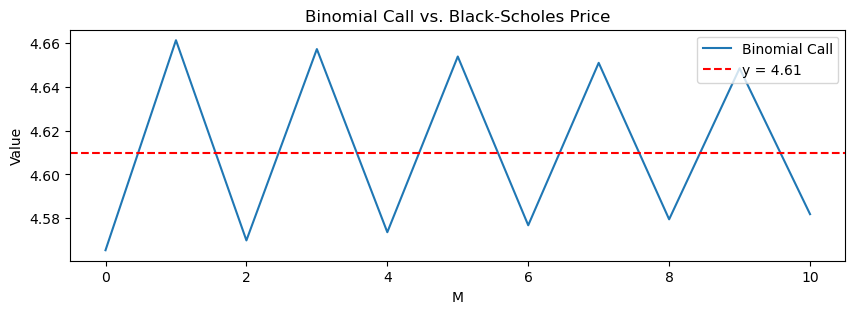

In [9]:
plt.figure(figsize=(10, 3))

plt.plot(binomial_price["Binomial Call"], label="Binomial Call")

plt.axhline(y=4.61, color='r', linestyle='--', label="y = 4.61")

plt.xlabel("M") 
plt.ylabel("Value")
plt.title("Binomial Call vs. Black-Scholes Price")

plt.legend()

plt.show()

### Now, we look at the distribution of the prices.

In a binomial pricing setting, the stock price at the end of a path is determined solely by the number of $u$'s and $d$'s characteristic of that path. Thus, if there are $N$ time steps, then there are $N+1$ different prices - from no $u$'s to all $u$'s (we're assuming that $d<1<u$).

How many paths have exactly $n_1$ $u$'s in each of them? Out of the $N$ time steps, there are exactly $^NC_{n_1}$ ways to insert those $n_1$ $u$'s - and that's the answer. Of course, there are $2^N$ possible paths, and of course $\displaystyle\sum_{n_1=0}^N{^NC_{n_1}}=2^N$.

Also, if path $\vec{S}_1$ has more $u$'s than $\vec{S}_2$ does, then the end-of-period price associated with $\vec{S}_1$ is greater than that of $\vec{S}_2$, i.e. $\vec{S}_1(N)>\vec{S}_2(N)$ (index starts with 0). Thus, let $s_{n_1}$ represent the end-of-period price of the stock under a path with exactly $n_1$ $u$'s; what we've just established is that $s_0<s_1<\cdots<s_N$. In fact, we have the following distribution:
\begin{equation}
    f(s_k)={^NC_k}.
\end{equation}

How many paths have end-of-period prices greater than the current spot price $S_0$? If $d=1/u$, then $s_k>S_0$ precisely when $k>N+1-k$ or $k>(N+1)/2$. If $N$ is an odd number, then the symmetry of $f(k)$ yields the number of paths as $2^{N-1}-f\left(\frac{N+1}{2}\right)$. On the other hand, if $N$ is an even number, then that number is $\frac{1}{2}\left(2^N-f\left(\frac{N}{2}\right)\right)$ (remove the ``middle piece," then take the remaining half).

### Let's first look at when $N=20$

In [10]:
M = 20 # The N that we've been alluding to...
price_dist = []
for r in range(0, M+1):
    dt = T/M
    u = np.exp(sigma * np.sqrt(dt))
    d = 1/u
    p = (np.exp(rf * dt) - d) / (u - d)
    q = 1-p
    price = float(S_ini*(u**r)*(d**(M-r)))
    freq = math.comb(M, r)
    price_dist.append({
        "r": int(r),
        "End Price": price,
        "Frequency": freq
    })

In [11]:
price_dist = pd.DataFrame(price_dist)
price_dist[-11:].T

,10,11,12,13,14,15,16,17,18,19,20
r,10.0,11.000000,12.000000,13.000000,14.000000,15.000000,16.000000,17.000000,18.00000,19.000000,20.000000
End Price,100.0,104.573643,109.356469,114.358044,119.588373,125.057919,130.777623,136.758925,143.01379,149.554731,156.394832
Frequency,184756.0,167960.000000,125970.000000,77520.000000,38760.000000,15504.000000,4845.000000,1140.000000,190.00000,20.000000,1.000000


In [12]:
price_dist['Prob.'] = (p**price_dist['r'])*(q**(M-price_dist['r']))

In [13]:
price_dist['Weighted Payoff'] = np.zeros(len(price_dist))
for r in range(0, 21):
    price_dist.loc[r, 'Weighted Payoff'] = (max((price_dist['End Price'][r]-K), 0))*(price_dist['Prob.'][r])*(price_dist['Frequency'][r])

price_dist.T

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
r,0.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00,6.000000e+00,7.000000e+00,8.000000e+00,9.000000e+00,...,1.100000e+01,12.000000,13.000000,14.000000,15.000000,16.000000,17.000000,18.000000,19.000000,20.000000
End Price,6.394073e+01,6.686515e+01,6.992333e+01,7.312137e+01,7.646568e+01,7.996295e+01,8.362017e+01,8.744466e+01,9.144406e+01,9.562639e+01,...,1.045736e+02,109.356469,114.358044,119.588373,125.057919,130.777623,136.758925,143.013790,149.554731,156.394832
Frequency,1.000000e+00,2.000000e+01,1.900000e+02,1.140000e+03,4.845000e+03,1.550400e+04,3.876000e+04,7.752000e+04,1.259700e+05,1.679600e+05,...,1.679600e+05,125970.000000,77520.000000,38760.000000,15504.000000,4845.000000,1140.000000,190.000000,20.000000,1.000000
Prob.,6.798879e-07,7.030906e-07,7.270852e-07,7.518987e-07,7.775590e-07,8.040950e-07,8.315366e-07,8.599148e-07,8.892614e-07,9.196095e-07,...,9.834482e-07,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001
Weighted Payoff,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,7.554742e-01,1.198684,1.170600,0.825763,0.436955,0.173440,0.050404,0.010166,0.001275,0.000075


The "weighted payoff" above means weighted by the probability that paths with $r$ "ups" would occur. The option price is thus weighted as well.

In [14]:
call_price = np.exp(-rf*T)*(price_dist['Weighted Payoff'].sum()/2**M)
print(f"Call price based on the averaging of payoffs from Binomial paths: {round(float(call_price), 2)}")

Call price based on the averaging of payoffs from Binomial paths: 0.0


The price looks ridiculous. Let us try with different values of $M$. Below are such weighted call option prices for $M=20, 21, 22, \ldots, 30$.

In [15]:
price_list = []
for M in range(20, 31):
        price_dist = []
        for r in range(0, M+1):
            dt = T/M
            u = np.exp(sigma * np.sqrt(dt))
            d = 1/u
            p = (np.exp(rf * dt) - d) / (u - d)
            q = 1-p
            price = float(S_ini*(u**r)*(d**(M-r)))
            freq = math.comb(M, r)
            price_dist.append({
                "r": int(r),
                "End Price": price,
                "Frequency": freq
            })
        price_dist = pd.DataFrame(price_dist)
        price_dist['Prob.'] = (p**price_dist['r'])*(q**(M-price_dist['r']))
        price_dist['Weighted Payoff'] = np.zeros(len(price_dist))
        for r in range(0, M+1):
            price_dist.loc[r, 'Weighted Payoff'] = (max((price_dist['End Price'][r]-K), 0))*(price_dist['Prob.'][r])*(price_dist['Frequency'][r])
        call_price = np.exp(-rf*T)*(price_dist['Weighted Payoff'].sum()/2**M)
        # print(f"Call price based on the averaging of payoffs from Binomial paths: {round(float(call_price), 2)}")
        price_list.append({
            "M": M,
            "Call Price": round(float(call_price), 10)
        })

price_list = pd.DataFrame(price_list)
price_list.T

,0,1,2,3,4,5,6,7,8,9,10
M,20.000000,21.000000,22.000000,2.300000e+01,2.400000e+01,2.500000e+01,2.600000e+01,2.700000e+01,2.800000e+01,2.900000e+01,3.000000e+01
Call Price,0.000004,0.000002,0.000001,5.552000e-07,2.726000e-07,1.387000e-07,6.820000e-08,3.470000e-08,1.710000e-08,8.700000e-09,4.300000e-09


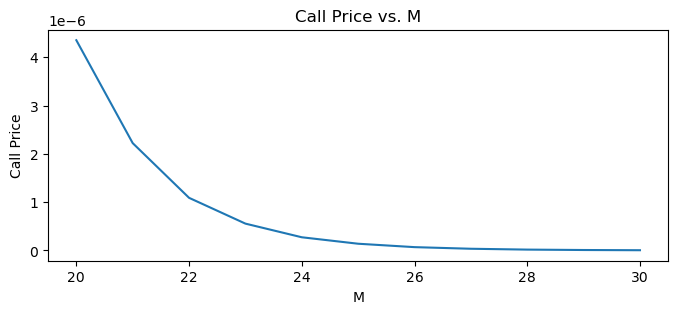

In [16]:
plt.figure(figsize=(8, 3))

plt.plot(price_list['M'], price_list['Call Price'])

plt.xlabel('M')
plt.ylabel('Call Price')
plt.title('Call Price vs. M')

plt.show()

## The X Method

The prices above look absolutely ridiculous. But what if we do not look at weighted payoffs and just take averages as if each path is equally likely to occur as another path? This is how Monte Carlo methods compute option prices. The following reflects such a computation. We shall from now on refer to this experimental method as the **X Method**.

In [17]:
price_list = []
for M in range(20, 31):
        price_dist = []
        for r in range(0, M+1):
            dt = T/M
            u = np.exp(sigma * np.sqrt(dt))
            d = 1/u
            price = float(S_ini*(u**r)*(d**(M-r)))
            freq = math.comb(M, r)
            price_dist.append({
                "r": int(r),
                "End Price": price,
                "Frequency": freq
            })
        price_dist = pd.DataFrame(price_dist)
        price_dist['Prob.'] = (p**price_dist['r'])*(q**(M-price_dist['r']))
        price_dist['Payoff'] = np.zeros(len(price_dist))
        for r in range(0, M+1):
            price_dist.loc[r, 'Payoff'] = (max((price_dist['End Price'][r]-K), 0))*(price_dist['Frequency'][r])
        call_price = np.exp(-rf*T)*(price_dist['Payoff'].sum()/2**M)
        # print(f"Call price based on the averaging of payoffs from Binomial paths: {round(float(call_price), 2)}")
        price_list.append({
            "M": M,
            "Call Price": round(float(call_price), 10),
            "Binomial Pricing Method": binomial_price["Binomial Call"].iloc[M-20]
        })

price_list = pd.DataFrame(price_list)
price_list.T

,0,1,2,3,4,5,6,7,8,9,10
M,20.00000,21.000000,22.000000,23.000000,24.000000,25.000000,26.000000,27.000000,28.000000,29.000000,30.000000
Call Price,4.15143,4.247522,4.155866,4.243417,4.159567,4.239972,4.162702,4.237039,4.165391,4.234512,4.167724
Binomial Pricing Method,4.56541,4.661246,4.569889,4.657206,4.573626,4.653815,4.576792,4.650928,4.579507,4.648441,4.581863


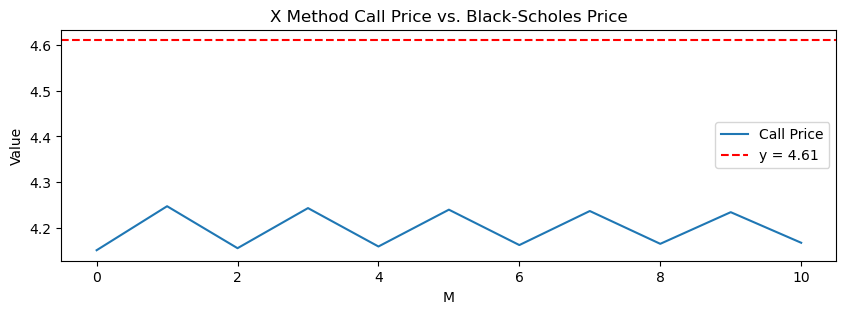

In [18]:
plt.figure(figsize=(10, 3))

plt.plot(price_list["Call Price"], label="Call Price")

plt.axhline(y=4.61, color='r', linestyle='--', label="y = 4.61")

plt.xlabel("M")
plt.ylabel("Value")
plt.title("X Method Call Price vs. Black-Scholes Price")

plt.legend()

plt.show()

We see that the price using the method we've been alluding to are consistently lower than the Black-Scholes price and the corresponding Binomial prices. We blame this on the thin-tailness of the Binomial distribution. We seek to fatten the tail. We begin by tabulating the "$r$-center" of each distribution with $M$ or $N=20, 21, 22, \ldots, 50$.

In [19]:
center_coll = []
for M in range(20, 71):
    median = (M+1)/2
    ctr = M/2
    if M%2 == 0:
        upstart = int(median+1)
    else:
        upstart = math.ceil(median)
    center_coll.append({
        "M": M,
        "Center": ctr,
        "Up-start": upstart
    })

center_coll = pd.DataFrame(center_coll)
center_coll.T

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
M,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,...,61.0,62.0,63.0,64.0,65.0,66.0,67.0,68.0,69.0,70.0
Center,10.0,10.5,11.0,11.5,12.0,12.5,13.0,13.5,14.0,14.5,...,30.5,31.0,31.5,32.0,32.5,33.0,33.5,34.0,34.5,35.0
Up-start,11.0,11.0,12.0,12.0,13.0,13.0,14.0,14.0,15.0,15.0,...,31.0,32.0,32.0,33.0,33.0,34.0,34.0,35.0,35.0,36.0


For each $M$, the "Center" is where the symmetrical axis of the distribution

We now create a multi-layer matrix for the different payoffs for $M=N=20, 21, 22, \ldots, 50$.

In [20]:
price_dist_coll = []
for M in range(20, 71):
        price_dist = []
        for r in range(0, M+1):
            dt = T/M
            u = np.exp(sigma * np.sqrt(dt))
            d = 1/u
            price = float(S_ini*(u**r)*(d**(M-r)))
            freq = math.comb(M, r)
            price_dist.append({
                "r": int(r),
                "End Price": price,
                "Frequency": freq
            })
        price_dist = pd.DataFrame(price_dist)
        price_dist_coll = price_dist_coll+[price_dist]

coll_dist = price_dist_coll
print("Example layer (N=20):")
price_dist_coll[0].T

Example layer (N=20):


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
r,0.000000,1.000000,2.000000,3.00000,4.000000,5.000000,6.000000,7.000000,8.000000,9.00000,...,11.000000,12.000000,13.000000,14.000000,15.000000,16.000000,17.000000,18.00000,19.000000,20.000000
End Price,63.940732,66.865153,69.923327,73.12137,76.465681,79.962949,83.620169,87.444657,91.444064,95.62639,...,104.573643,109.356469,114.358044,119.588373,125.057919,130.777623,136.758925,143.01379,149.554731,156.394832
Frequency,1.000000,20.000000,190.000000,1140.00000,4845.000000,15504.000000,38760.000000,77520.000000,125970.000000,167960.00000,...,167960.000000,125970.000000,77520.000000,38760.000000,15504.000000,4845.000000,1140.000000,190.00000,20.000000,1.000000


Our strategy to fatten the tails of the Binomial distribution is through a kernel. We use a simple linear kernel
\begin{equation}
K_\alpha(r)=\alpha\left\lvert\frac{8.2}{N}r-4.1\right\rvert+0.9,
\end{equation}
where $N$ is the number of "Bernoulli trials," $r\in\{0, 1, 2, \ldots, N\}$, and $\alpha$ is the parameter to be tuned for a "proper" fattening. With $\alpha=1$, this kernel will cut down $10\%$ of the original frequency from the center $N/2$, and more moving outwards from the center $r=N/2$, the frequencies will vary linearly until $500\%$ of the tail tip frequencies get added to the tail tips. By lowering $\alpha$ from 1 towards 0, we tilt the line down assuming the center is the pivot, thus adding less frequencies at the tail tips while still taking away lesser and lesser away from the center. On the other hand, increasing $\alpha$ adds more frequencies to the tail.

In [21]:
def kernel(x, M, alpha):
    return alpha*abs((8.2*x/M)-4.1)+0.9

def erf(alpha):
        df = price_dist_coll[m]
        M = m+20
        ups = int(center_coll['Up-start'][m])
        df["Adjusted Freq."] = df["Frequency"]*(kernel(df["r"], M, alpha))
        terms = []
        for r in range(0, M+1):
            term = (max(df['End Price'][r]-K, 0))*(df['Adjusted Freq.'][r])
            terms = terms+[term]
        sum_mod_price = sum(terms)
        call_price = np.exp(-rf*T)*(sum_mod_price/2**M)
        bs_call_price = round(bs_price['Binomial Call'][9], 2) #This is the Black-Scholes call price that has been computed above.
        return float(abs(call_price-bs_call_price))

In [22]:
Err_Val = []
for m in range(0, 51):
    ctr = center_coll["Center"][m]
    error_val = erf(1)
    Err_Val.append({
        "M": int(m+20),
        "Error Value": float(error_val)
    })

Err_Val = pd.DataFrame(Err_Val)
Err_Val.T

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
M,20.000000,21.000000,22.000000,23.00000,24.00000,25.00000,26.000000,27.000000,28.000000,29.000000,...,61.000000,62.000000,63.00000,64.00000,65.000000,66.000000,67.000000,68.000000,69.00000,70.000000
Error Value,4.033064,4.001437,3.809166,3.78523,3.61367,3.59561,3.441032,3.427543,3.287115,3.277237,...,1.996638,1.945066,1.95122,1.90162,1.907919,1.860157,1.866577,1.820529,1.82705,1.782605


In [23]:
Opt_Val = []
for m in range(0, 51):
    ctr = center_coll["Center"][m]
    constraints = ({'type': 'ineq', 'fun': lambda x: x[0]})
    res = minimize(erf, 1, constraints=constraints)
    Opt_Val.append({
        "M": int(m+20),
        "Opt. Factor": float(res['x'][0])
    })

Opt_Val = pd.DataFrame(Opt_Val)
Opt_Val.T

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
M,20.000000,21.000000,22.000000,23.000000,24.000000,25.000000,26.000000,27.000000,28.000000,29.000000,...,61.000000,62.00000,63.000000,64.000000,65.000000,66.000000,67.000000,68.000000,69.000000,70.000000
Opt. Factor,0.178062,0.164395,0.185882,0.172836,0.193388,0.180886,0.200615,0.188595,0.207592,0.196002,...,0.289869,0.30257,0.294746,0.307245,0.299544,0.311851,0.304266,0.316389,0.308916,0.320863


In [24]:
Rev_Err_Val = []
for m in range(0, 51):
    ctr = center_coll["Center"][m]
    error_val = erf(Opt_Val["Opt. Factor"][m])
    Rev_Err_Val.append({
        "M": int(m+20),
        "Error Amount": float(error_val)
    })

Rev_Err_Val = pd.DataFrame(Rev_Err_Val)
Rev_Err_Val.T

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
M,2.000000e+01,21.000000,2.200000e+01,2.300000e+01,2.400000e+01,2.500000e+01,2.600000e+01,2.700000e+01,2.800000e+01,2.900000e+01,...,6.100000e+01,6.200000e+01,6.300000e+01,6.400000e+01,6.500000e+01,6.600000e+01,6.700000e+01,6.800000e+01,6.900000e+01,7.000000e+01
Error Amount,1.534297e-08,0.000001,3.493713e-08,1.011598e-07,7.736336e-07,2.819315e-08,2.170418e-07,1.835297e-07,8.997434e-08,9.151729e-08,...,8.250087e-09,7.048684e-07,2.479553e-08,6.766596e-07,1.877319e-07,1.105425e-08,7.902732e-09,6.137251e-10,1.148548e-09,2.255683e-08


In [25]:
def adj_call_price(alpha):
        df = price_dist_coll[m]
        M = m+20
        ups = int(center_coll['Up-start'][m])
        df["Adjusted Freq."] = df["Frequency"]*(kernel(df["r"], M, alpha))
        terms = []
        for r in range(ups, M+1):
            term = (max(df['End Price'].loc[r]-K, 0))*(df['Adjusted Freq.'][r])
            terms = terms+[term]
        sum_mod_price = sum(terms)
        call_price = np.exp(-rf*T)*(sum_mod_price/2**M)
        return float(call_price)

adj_price_coll = []
for m in range(0, 51):
    ctr = center_coll["Center"][m]
    adj_price = adj_call_price(Opt_Val["Opt. Factor"][m])
    adj_price_coll.append({
        "M": int(m+20),
        "Adjusted Price (Call)": float(adj_price)
    })

adj_price_coll = pd.DataFrame(adj_price_coll)
adj_price_coll.T

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
M,20.00,21.000000,22.00,23.00,24.000000,25.00,26.00,27.00,28.00,29.00,...,61.00,62.000000,63.00,64.000000,65.00,66.00,67.00,68.00,69.00,70.00
Adjusted Price (Call),4.61,4.610001,4.61,4.61,4.609999,4.61,4.61,4.61,4.61,4.61,...,4.61,4.610001,4.61,4.609999,4.61,4.61,4.61,4.61,4.61,4.61


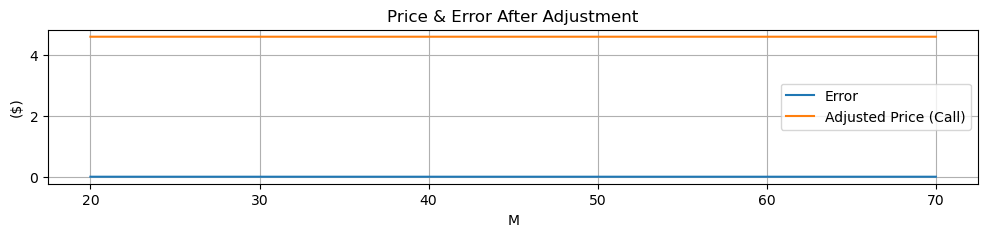

In [26]:
plt.figure(figsize=(12, 2))

plt.plot(Rev_Err_Val['M'], Rev_Err_Val["Error Amount"], label=r'Error')
plt.plot(Rev_Err_Val['M'], adj_price_coll["Adjusted Price (Call)"], label='Adjusted Price (Call)')

plt.xlabel('M')
plt.ylabel('($)')
plt.title('Price & Error After Adjustment')
plt.legend()
plt.grid(True)

# plt.savefig("flat.jpg")

plt.show()

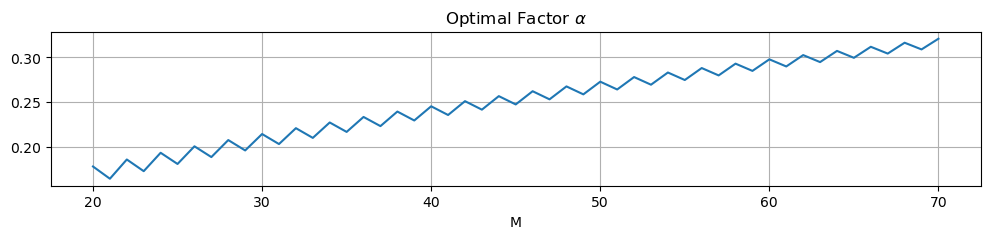

In [27]:
plt.figure(figsize=(12, 2))
plt.plot(Rev_Err_Val['M'], Opt_Val["Opt. Factor"])

plt.xlabel('M')
plt.ylabel('')
plt.title(r'Optimal Factor $\alpha$')
plt.grid(True)

plt.show()

In [28]:
df = coll_dist[0]
df["Kernel Value"] = kernel(df["r"], 20, Opt_Val['Opt. Factor'][0])
df.T

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
r,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,...,11.000000,12.000000,13.000000,14.000000,15.000000,16.000000,17.000000,18.000000,19.000000,20.000000
End Price,63.940732,66.865153,69.923327,73.121370,76.465681,79.962949,83.620169,87.444657,91.444064,95.626390,...,104.573643,109.356469,114.358044,119.588373,125.057919,130.777623,136.758925,143.013790,149.554731,156.394832
Frequency,1.000000,20.000000,190.000000,1140.000000,4845.000000,15504.000000,38760.000000,77520.000000,125970.000000,167960.000000,...,167960.000000,125970.000000,77520.000000,38760.000000,15504.000000,4845.000000,1140.000000,190.000000,20.000000,1.000000
Adjusted Freq.,1.630056,31.141008,281.968514,1608.584700,6482.772835,19612.994226,46202.788452,86746.182679,131766.031235,163426.020824,...,163426.020824,131766.031235,86746.182679,46202.788452,19612.994226,6482.772835,1608.584700,281.968514,31.141008,1.630056
Kernel Value,1.630056,1.557050,1.484045,1.411039,1.338034,1.265028,1.192022,1.119017,1.046011,0.973006,...,0.973006,1.046011,1.119017,1.192022,1.265028,1.338034,1.411039,1.484045,1.557050,1.630056


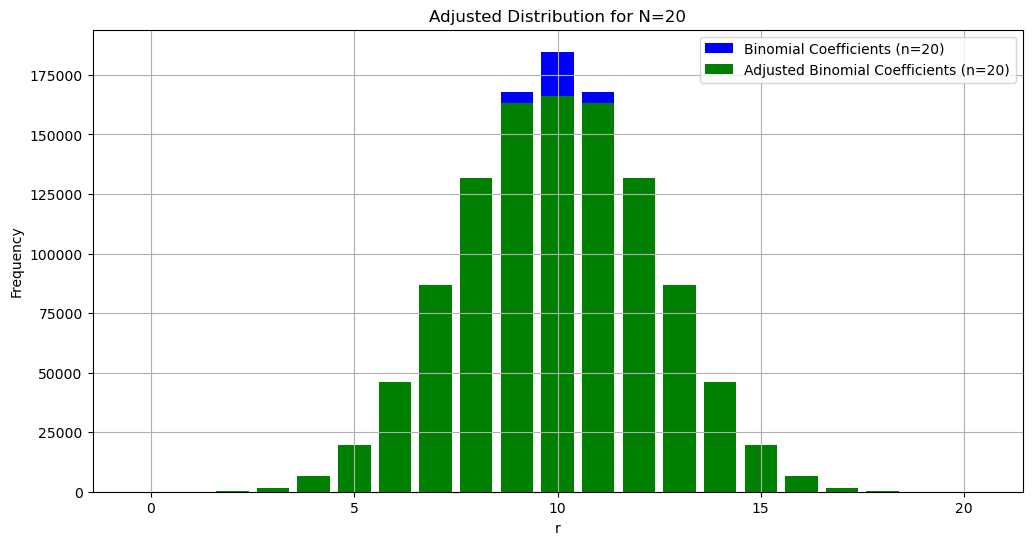

In [29]:
plt.figure(figsize=(12, 6))

plt.bar(price_dist_coll[0]['r'], price_dist_coll[0]['Frequency'], color='blue', label='Binomial Coefficients (n=20)')
plt.bar(price_dist_coll[0]['r'], price_dist_coll[0]['Adjusted Freq.'], color='green', label='Adjusted Binomial Coefficients (n=20)')

plt.xlabel('r')
plt.ylabel('Frequency')
plt.title('Adjusted Distribution for N=20')
plt.legend()
plt.grid(True)

plt.show()

As we see from the above, the distribution is now fat-tailed. The original binomial distribution is now hidden behind the adjusted fat-tailed distribution, except for the middle three bars. Let's do another adjusted frequency plot at the other end, where $N=50$.

In [30]:
df = coll_dist[30]
df["Kernel Value"] = kernel(df["r"], 50, Opt_Val['Opt. Factor'][30])
df.T

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
r,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000e+00,6.000000e+00,7.000000e+00,8.000000e+00,9.000000e+00,...,4.100000e+01,4.200000e+01,4.300000e+01,4.400000e+01,4.500000e+01,46.000000,47.000000,48.000000,49.000000,50.000000
End Price,49.306869,50.721388,52.176487,53.673329,55.213114,5.679707e+01,5.842647e+01,6.010261e+01,6.182684e+01,6.360053e+01,...,1.572314e+02,1.617421e+02,1.663821e+02,1.711553e+02,1.760654e+02,181.116393,186.312273,191.657212,197.155488,202.811498
Frequency,1.000000,50.000000,1225.000000,19600.000000,230300.000000,2.118760e+06,1.589070e+07,9.988440e+07,5.368786e+08,2.505434e+09,...,2.505434e+09,5.368786e+08,9.988440e+07,1.589070e+07,2.118760e+06,230300.000000,19600.000000,1225.000000,50.000000,1.000000
Adjusted Freq.,2.018655,98.695451,2363.224436,36934.565282,423676.090155,3.803014e+06,2.781155e+07,1.703460e+08,8.915866e+08,4.048629e+09,...,4.048629e+09,8.915866e+08,1.703460e+08,2.781155e+07,3.803014e+06,423676.090155,36934.565282,2363.224436,98.695451,2.018655
Kernel Value,2.018655,1.973909,1.929163,1.884417,1.839670,1.794924e+00,1.750178e+00,1.705432e+00,1.660686e+00,1.615939e+00,...,1.615939e+00,1.660686e+00,1.705432e+00,1.750178e+00,1.794924e+00,1.839670,1.884417,1.929163,1.973909,2.018655


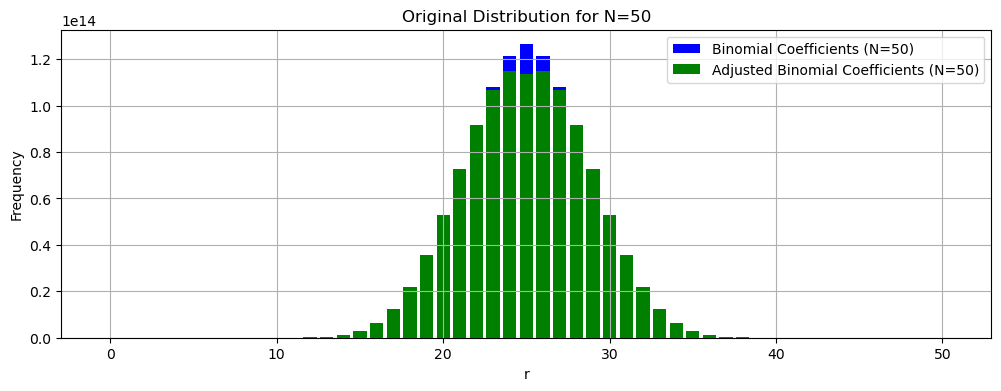

In [31]:
plt.figure(figsize=(12, 4))

plt.bar(price_dist_coll[30]['r'], price_dist_coll[30]['Frequency'], color='blue', label='Binomial Coefficients (N=50)')
plt.bar(price_dist_coll[30]['r'], price_dist_coll[30]['Adjusted Freq.'], color='green', label='Adjusted Binomial Coefficients (N=50)')

plt.xlabel('r')
plt.ylabel('Frequency')
plt.title('Original Distribution for N=50')
plt.legend()
plt.grid(True)

plt.show()

As we can see, the distribution with $N=50$ is also fat-tailed, except for the fact that it is not unimodal, but we shall omit that for this simple exercise and we can, in fact, think of it as reflecting skewness in the the returns.

Let us now return to the optimal $\alpha$s, whose plot is given above. The plot suggests a linear relationship for the odd $N$s, as well as for the even $N$s. This kernel method to fatten the tails of the binomial distribution to compute options price simply will only be _meaningful_ if we can obtain the values of $\alpha$ as a function of $M$ simply - and it definitely appears so with its apparent linearity!  We should be able to demonstrate whether it is linear or not using algebra, but let us attempt a statistical approach using regression.

In [32]:
even = [M for M in range(20, 51) if M%2==0]
odd = [M for M in range(20, 51) if M%2==1]

Opt_Val_even = pd.DataFrame([x for x in Opt_Val.to_dict('records') if int(x['M']) in even])
Opt_Val_odd = pd.DataFrame([x for x in Opt_Val.to_dict('records') if int(x['M']) in odd])

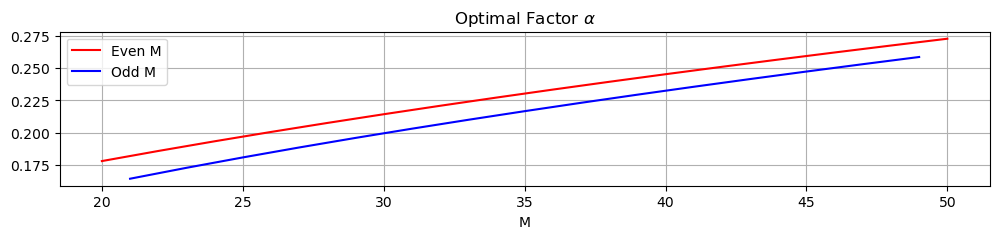

In [33]:
plt.figure(figsize=(12, 2))

plt.plot(Opt_Val_even['M'], Opt_Val_even["Opt. Factor"], color='red', label='Even M')
plt.plot(Opt_Val_odd['M'], Opt_Val_odd["Opt. Factor"], color='blue', label='Odd M')

plt.xlabel('M')
plt.ylabel('')
plt.title(r'Optimal Factor $\alpha$')
plt.legend()
plt.grid(True)

plt.show()

We begin by running a regression on the even $N$s and make predictions for $N=60$. We do expect a correlation coefficient $\rho_0$ of 1. Indeed, we see below that $\rho_0^2=0.997$ or $\rho_0=0.9985$. It is not exactly 1, but very close. This implies that the $\alpha$s do not depend on $M$ linearly (for even $M$s or for odd $M$s), but very close. Therefore, for $M$s not too distant away from 50, the predicted $\alpha$s should be very accurate.

In [34]:
# Prepare the data for regression
X = Opt_Val_even['M']
y = Opt_Val_even['Opt. Factor']

# Add a constant term to the predictor (for the intercept)
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

intercept = results.params['const']
slope = results.params['M']

print(f"Intercept: {intercept}")
print(f"Slope: {slope}")

                            OLS Regression Results                            
Dep. Variable:            Opt. Factor   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     4275.
Date:                Thu, 20 Mar 2025   Prob (F-statistic):           8.28e-19
Time:                        20:48:48   Log-Likelihood:                 79.760
No. Observations:                  16   AIC:                            -155.5
Df Residuals:                      14   BIC:                            -154.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1187      0.002     68.381      0.0

In [35]:
# Function to predict Opt. Factor for a given M
def predict_opt_factor(M_value):
    return intercept+(slope*M_value)

We now use this regression model to predict the prices. If the model is accurate, the prices should come out around the Black-Scholes price of 4.61.

In [36]:
price_dist_coll = []
for M in range(20, 71):
        price_dist = []
        for r in range(0, M+1):
            dt = T/M
            u = np.exp(sigma * np.sqrt(dt))
            d = 1/u
            price = float(S_ini*(u**r)*(d**(M-r)))
            freq = math.comb(M, r)
            price_dist.append({
                "r": int(r),
                "End Price": price,
                "Frequency": freq
            })
        price_dist = pd.DataFrame(price_dist)
        price_dist_coll = price_dist_coll+[price_dist]

coll_dist = price_dist_coll
print("Example layer (N=51):")
price_dist_coll[0].T

Example layer (N=51):


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
r,0.000000,1.000000,2.000000,3.00000,4.000000,5.000000,6.000000,7.000000,8.000000,9.00000,...,11.000000,12.000000,13.000000,14.000000,15.000000,16.000000,17.000000,18.00000,19.000000,20.000000
End Price,63.940732,66.865153,69.923327,73.12137,76.465681,79.962949,83.620169,87.444657,91.444064,95.62639,...,104.573643,109.356469,114.358044,119.588373,125.057919,130.777623,136.758925,143.01379,149.554731,156.394832
Frequency,1.000000,20.000000,190.000000,1140.00000,4845.000000,15504.000000,38760.000000,77520.000000,125970.000000,167960.00000,...,167960.000000,125970.000000,77520.000000,38760.000000,15504.000000,4845.000000,1140.000000,190.00000,20.000000,1.000000


In [37]:
center_coll = []
for M in range(20, 71):
    median = (M+1)/2
    ctr = M/2
    if M%2 == 0:
        upstart = int(median+1)
    else:
        upstart = math.ceil(median)
    center_coll.append({
        "M": M,
        "Center": ctr,
        "Up-start": upstart
    })

center_coll = pd.DataFrame(center_coll)
center_coll.T

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
M,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,...,61.0,62.0,63.0,64.0,65.0,66.0,67.0,68.0,69.0,70.0
Center,10.0,10.5,11.0,11.5,12.0,12.5,13.0,13.5,14.0,14.5,...,30.5,31.0,31.5,32.0,32.5,33.0,33.5,34.0,34.5,35.0
Up-start,11.0,11.0,12.0,12.0,13.0,13.0,14.0,14.0,15.0,15.0,...,31.0,32.0,32.0,33.0,33.0,34.0,34.0,35.0,35.0,36.0


In [38]:
def adj_call_price(alpha):
        df = price_dist_coll[m]
        M = m+20
        df["Adjusted Freq."] = df["Frequency"]*(kernel(df["r"], M, alpha))
        terms = []
        for r in range(0, M+1):
            term = (max(df['End Price'].loc[r]-K, 0))*(df['Adjusted Freq.'][r])
            terms = terms+[term]
        sum_mod_price = sum(terms)
        call_price = np.exp(-rf*T)*(sum_mod_price/2**M)
        return float(call_price)

adj_price_coll = []
for m in range(0, 51):
    M = m+20
    ctr = center_coll["Center"][m]
    adj_price = adj_call_price(predict_opt_factor(M))
    adj_price_coll.append({
        "M": int(M),
        "Adjusted Price (Call)": float(adj_price)
    })

adj_price_coll = pd.DataFrame(adj_price_coll)

In [39]:
even_new = [M for M in range(20, 71) if M%2==0]
odd_new = [M for M in range(20, 71) if M%2==1]

adj_price_coll_even = pd.DataFrame([x for x in adj_price_coll.to_dict('records') if int(x['M']) in even_new])
adj_price_coll_odd = pd.DataFrame([x for x in adj_price_coll.to_dict('records') if int(x['M']) in odd_new])

In [40]:
adj_price_coll_even.T

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
M,20.000000,22.000000,24.000000,26.000000,28.000000,30.000000,32.000000,34.00000,36.00000,38.000000,...,52.000000,54.000000,56.000000,58.000000,60.000000,62.000000,64.000000,66.000000,68.000000,70.000000
Adjusted Price (Call),4.626785,4.618775,4.612883,4.608667,4.605799,4.604028,4.603163,4.60305,4.60357,4.604624,...,4.621727,4.625075,4.628568,4.632189,4.635923,4.639756,4.643677,4.647674,4.651739,4.655863


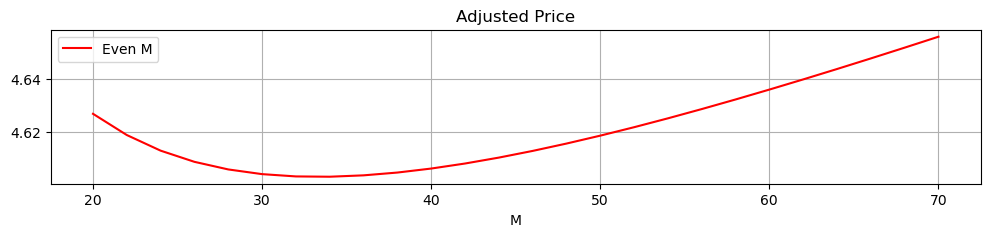

In [41]:
plt.figure(figsize=(12, 2))

plt.plot(adj_price_coll_even['M'], adj_price_coll_even["Adjusted Price (Call)"], color='red', label='Even M')
# plt.plot(Opt_Val_odd['M'], Opt_Val_odd["Opt. Factor"], color='blue', label='Odd M')

plt.xlabel('M')
plt.ylabel('')
plt.title('Adjusted Price')
plt.legend()
plt.grid(True)

plt.show()

In [42]:
alpha_coll = []
for m in range(0, 51):
    M = m+20
    ctr = center_coll["Center"][m]
    alpha = predict_opt_factor(M)
    alpha_coll.append({
        "M": int(M),
        r"$\alpha$": float(alpha)
    })

alpha_coll = pd.DataFrame(alpha_coll)
alpha_coll.T

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
M,20.000000,21.00000,22.000000,23.000000,24.000000,25.000000,26.000000,27.000000,28.00000,29.000000,...,61.000000,62.00000,63.000000,64.000000,65.000000,66.000000,67.000000,68.000000,69.000000,70.000000
$\alpha$,0.181483,0.18462,0.187757,0.190894,0.194031,0.197168,0.200306,0.203443,0.20658,0.209717,...,0.310103,0.31324,0.316377,0.319514,0.322651,0.325788,0.328925,0.332062,0.335199,0.338336


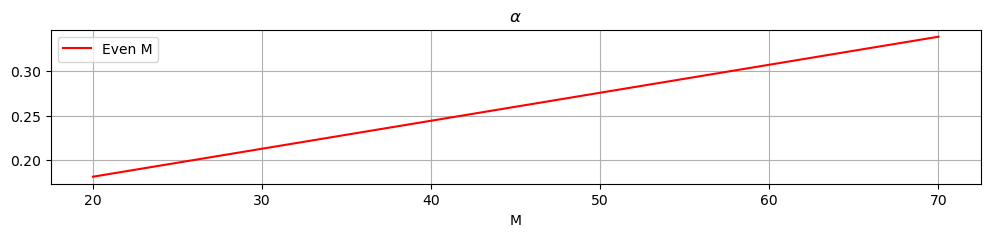

In [43]:
plt.figure(figsize=(12, 2))

plt.plot(alpha_coll['M'], alpha_coll[r"$\alpha$"], color='red', label='Even M')
# plt.plot(Opt_Val_odd['M'], Opt_Val_odd["Opt. Factor"], color='blue', label='Odd M')

plt.xlabel('M')
plt.ylabel('')
plt.title(r'$\alpha$')
plt.legend()
plt.grid(True)

plt.show()

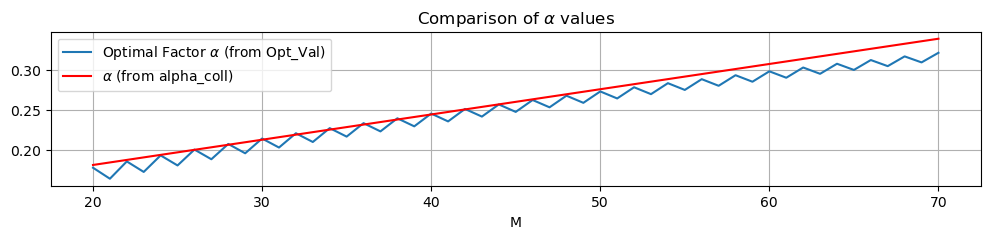

In [44]:
plt.figure(figsize=(12, 2))

plt.plot(Rev_Err_Val['M'], Opt_Val["Opt. Factor"], label=r'Optimal Factor $\alpha$ (from Opt_Val)')

plt.plot(alpha_coll['M'], alpha_coll[r"$\alpha$"], color='red', label=r'$\alpha$ (from alpha_coll)')

plt.xlabel('M')
plt.ylabel('')
plt.title(r'Comparison of $\alpha$ values')  # More descriptive title
plt.grid(True)
plt.legend()
plt.show()

The plot clearly shows that the $\alpha$s do not increase linearly with $M$ even when parity (even or odd $M$s) is taken into account. We shall now attempt a quadratic regression, but first, to train our model, we need to reconstruct the full list of even values (and odd values) as well, for recall that we truncated it to $M$ ranging from 20 to 50 earlier.

In [45]:
even = [M for M in range(20, 71) if M%2==0]
odd = [M for M in range(20, 71) if M%2==1]

Opt_Val_even = pd.DataFrame([x for x in Opt_Val.to_dict('records') if int(x['M']) in even])
Opt_Val_odd = pd.DataFrame([x for x in Opt_Val.to_dict('records') if int(x['M']) in odd])

In [46]:
## Training a quadratic regression model.

X = Opt_Val_even['M']
y = Opt_Val_even['Opt. Factor']

X_squared = X**2
X = pd.DataFrame({'M': X, 'M_squared': X_squared})
X = sm.add_constant(X)

# Fit the quadratic regression model
model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

intercept = results.params['const']
slope = results.params['M']
quadratic_term = results.params['M_squared']

print(f"Intercept: {intercept}")
print(f"Slope (M): {slope}")
print(f"Quadratic Term (M^2): {quadratic_term}")

                            OLS Regression Results                            
Dep. Variable:            Opt. Factor   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.957e+04
Date:                Thu, 20 Mar 2025   Prob (F-statistic):           1.77e-45
Time:                        20:48:49   Log-Likelihood:                 161.80
No. Observations:                  26   AIC:                            -317.6
Df Residuals:                      23   BIC:                            -313.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1008      0.001    105.970      0.0

In [47]:
# The quadratic function obtained from the regression
def quad_predict_opt_factor(M_value):
    return intercept+(slope*M_value)+(quadratic_term*M_value**2)

In [48]:
quad_adj_price_coll = []
for m in range(0, 51):
    M = m+20
    ctr = center_coll["Center"][m]
    adj_price = adj_call_price(quad_predict_opt_factor(M))
    quad_adj_price_coll.append({
        "M": int(M),
        "Adjusted Price (Call)": (adj_price)
    })

quad_adj_price_coll = pd.DataFrame(quad_adj_price_coll)

Let's use this quadratic model to compute the $\alpha$s, hence the prices, of the call options obtained this way. Plots follow.

In [49]:
quad_alpha_coll = []
for m in range(0, 51):
    M = m+20
    ctr = center_coll["Center"][m]
    alpha = quad_predict_opt_factor(M)
    quad_alpha_coll.append({
        "M": int(M),
        r"$\alpha$": float(alpha)
    })

quad_alpha_coll = pd.DataFrame(quad_alpha_coll)
quad_alpha_coll.T

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
M,20.000000,21.00000,22.00000,23.000000,24.000000,25.000000,26.000000,27.000000,28.000000,29.000000,...,61.000000,62.000000,63.000000,64.000000,65.000000,66.000000,67.000000,68.000000,69.000000,70.000000
$\alpha$,0.179268,0.18286,0.18642,0.189948,0.193444,0.196909,0.200342,0.203743,0.207113,0.210451,...,0.300533,0.302825,0.305086,0.307315,0.309512,0.311677,0.313811,0.315913,0.317983,0.320022


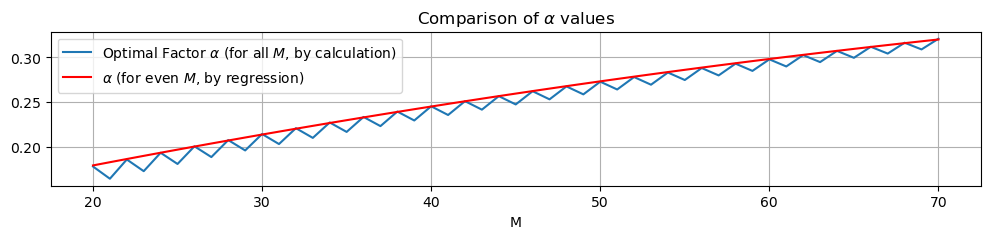

In [50]:
plt.figure(figsize=(12, 2))

plt.plot(Rev_Err_Val['M'], Opt_Val["Opt. Factor"], label=r'Optimal Factor $\alpha$ (for all $M$, by calculation)')

plt.plot(quad_alpha_coll['M'], quad_alpha_coll[r"$\alpha$"], color='red', label=r'$\alpha$ (for even $M$, by regression)')

plt.xlabel('M')
plt.ylabel('')
plt.title(r'Comparison of $\alpha$ values')
plt.grid(True)
plt.legend()
plt.show()

In [51]:
even = [M for M in range(20, 71) if M%2==0]
odd = [M for M in range(20, 71) if M%2==1]

quad_adj_price_coll_even = pd.DataFrame([x for x in quad_adj_price_coll.to_dict('records') if int(x['M']) in even])

quad_adj_price_coll_even.T

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
M,20.000000,22.000000,24.000000,26.000000,28.000000,30.00000,32.000000,34.000000,36.000000,38.0000,...,52.0000,54.000000,56.000000,58.000000,60.0000,62.000000,64.000000,66.000000,68.000000,70.000000
Adjusted Price (Call),4.615917,4.612516,4.610252,4.608824,4.608011,4.60765,4.607614,4.607807,4.608156,4.6086,...,4.6114,4.611501,4.611489,4.611358,4.6111,4.610713,4.610191,4.609531,4.608732,4.607792


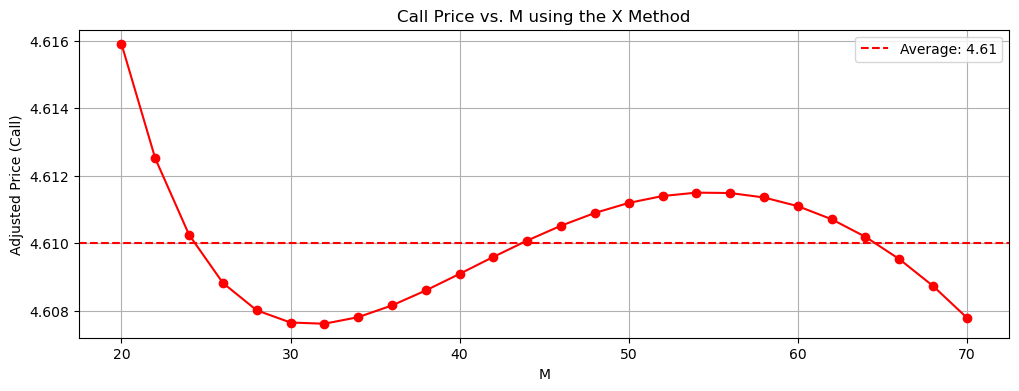

In [52]:
plt.figure(figsize=(12, 4))

call_even_X = np.mean(quad_adj_price_coll_even['Adjusted Price (Call)'])
plt.axhline(y=call_even_X, color='red', linestyle='--', label=f'Average: {call_even_X:.2f}')

plt.plot(quad_adj_price_coll_even['M'], quad_adj_price_coll_even['Adjusted Price (Call)'], marker='o', color="red", linestyle='-')

plt.xlabel('M')
plt.ylabel('Adjusted Price (Call)')
plt.title('Call Price vs. M using the X Method')
plt.legend()
plt.grid(True)

plt.show()

As we observed in the two plots above, the $\alpha$ values are we well approximated by the quadratic regression, and while the price curve exhibits rise and dip, the variation is bounded within 0.004 for the range of $M$ we considered.

### What about put options?

Let's us now see how good our kernel method works for put options. This time, we will take only the odd $M$s when considering regression.

In [53]:
def kernel(x, M, alpha):
    return alpha*abs((8.2*x/M)-4.1)+0.9

def erf(alpha):
        df = price_dist_coll[m]
        M = m+20
        ups = int(center_coll['Up-start'][m])
        df["Adjusted Freq."] = df["Frequency"]*(kernel(df["r"], M, alpha))
        terms = []
        for r in range(0, M+1):
            term = (max(K-df['End Price'][r], 0))*(df['Adjusted Freq.'][r])
            terms = terms+[term]
        sum_mod_price = sum(terms)
        put_price = np.exp(-rf*T)*(sum_mod_price/2**M)
        bs_put_price = round(bs_price['Binomial Put'][9], 2) #This is the Black-Scholes call price that has been computed above.
        return float(abs(put_price-bs_put_price))

In [54]:
Err_Val_p = []
for m in range(0, 51):
    ctr = center_coll["Center"][m]
    error_val = erf(1)
    Err_Val_p.append({
        "M": int(m+20),
        "Error Value": float(error_val)
    })

Err_Val_p = pd.DataFrame(Err_Val_p)
Err_Val_p.T

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
M,20.000000,21.000000,22.000000,23.00000,24.000000,25.000000,26.000000,27.000000,28.000000,29.000000,...,61.000000,62.000000,63.000000,64.000000,65.000000,66.000000,67.000000,68.000000,69.00000,70.000000
Error Value,4.111881,4.097286,3.920501,3.91141,3.753459,3.748489,3.605993,3.604159,3.474553,3.475138,...,2.377833,2.329565,2.338972,2.292525,2.301927,2.257175,2.266561,2.223391,2.23275,2.191062


In [55]:
Opt_Val_p = []
for m in range(0, 51):
    ctr = center_coll["Center"][m]
    constraints = ({'type': 'ineq', 'fun': lambda x: x[0]})
    res = minimize(erf, 1, constraints=constraints)
    Opt_Val_p.append({
        "M": int(m+20),
        "Opt. Factor": float(res['x'][0])
    })

Opt_Val_p = pd.DataFrame(Opt_Val_p)
Opt_Val_p.T

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
M,20.000000,2.100000e+01,22.000000,2.300000e+01,24.000000,2.500000e+01,26.000000,27.000000,28.00000,29.000000,...,61.000000,62.000000,63.000000,64.000000,65.000000,66.000000,67.000000,68.000000,69.000000,70.000000
Opt. Factor,0.018897,3.996803e-15,0.018823,4.884981e-15,0.018791,-4.884981e-15,0.018792,0.000599,0.01882,0.001275,...,0.008556,0.020745,0.008891,0.020886,0.009218,0.021028,0.009536,0.021171,0.009848,0.021314


In [56]:
Rev_Err_Val_p = []
for m in range(0, 51):
    ctr = center_coll["Center"][m]
    error_val = erf(Opt_Val_p["Opt. Factor"][m])
    Rev_Err_Val_p.append({
        "M": int(m+20),
        "Error Amount": float(error_val)
    })

Rev_Err_Val_p = pd.DataFrame(Rev_Err_Val_p)
Rev_Err_Val_p.T

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
M,2.000000e+01,21.000000,2.200000e+01,23.000000,2.400000e+01,25.000000,2.600000e+01,2.700000e+01,2.800000e+01,2.900000e+01,...,6.100000e+01,6.200000e+01,6.300000e+01,6.400000e+01,6.500000e+01,6.600000e+01,6.700000e+01,6.800000e+01,6.900000e+01,7.000000e+01
Error Amount,9.724960e-07,0.007283,1.719499e-09,0.003585,1.094786e-09,0.000482,6.072544e-09,1.858896e-07,3.575718e-09,3.121625e-09,...,5.514472e-09,6.526235e-08,2.764346e-08,4.454011e-07,2.391681e-08,2.024726e-07,2.681658e-07,4.629500e-07,7.167790e-08,3.573684e-10


In [57]:
def adj_put_price(alpha):
        df = price_dist_coll[m]
        M = m+20
        ups = int(center_coll['Up-start'][m])
        df["Adjusted Freq."] = df["Frequency"]*(kernel(df["r"], M, alpha))
        terms = []
        for r in range(0, M+1):
            term = (max(K-df['End Price'].loc[r], 0))*(df['Adjusted Freq.'][r])
            terms = terms+[term]
        sum_mod_price = sum(terms)
        put_price = np.exp(-rf*T)*(sum_mod_price/2**M)
        return float(put_price)

adj_price_coll_p = []
for m in range(0, 51):
    ctr = center_coll["Center"][m]
    adj_price = adj_put_price(Opt_Val_p["Opt. Factor"][m])
    adj_price_coll_p.append({
        "M": int(m+20),
        "Adjusted Price (Put)": float(adj_price)
    })

adj_price_coll_p = pd.DataFrame(adj_price_coll_p)
adj_price_coll_p.T

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
M,20.000000,21.000000,22.00,23.000000,24.00,25.000000,26.00,27.00,28.00,29.00,...,61.00,62.00,63.00,64.00,65.00,66.00,67.00,68.00,69.00,70.00
Adjusted Price (Put),3.369999,3.377283,3.37,3.373585,3.37,3.370482,3.37,3.37,3.37,3.37,...,3.37,3.37,3.37,3.37,3.37,3.37,3.37,3.37,3.37,3.37


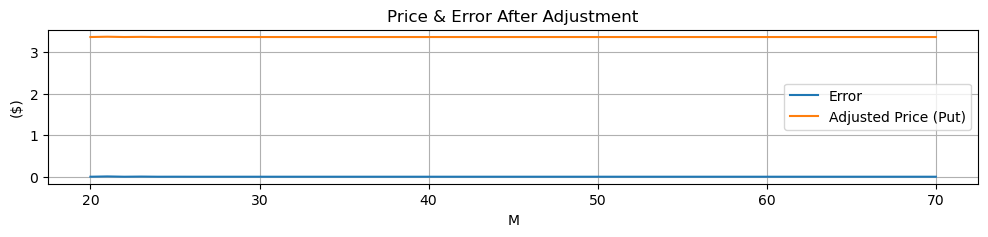

In [58]:
plt.figure(figsize=(12, 2))

plt.plot(Rev_Err_Val_p['M'], Rev_Err_Val_p["Error Amount"], label=r'Error')
plt.plot(Rev_Err_Val_p['M'], adj_price_coll_p["Adjusted Price (Put)"], label='Adjusted Price (Put)')

plt.xlabel('M')
plt.ylabel('($)')
plt.title('Price & Error After Adjustment')
plt.legend()
plt.grid(True)

# plt.savefig("flat.jpg")

plt.show()

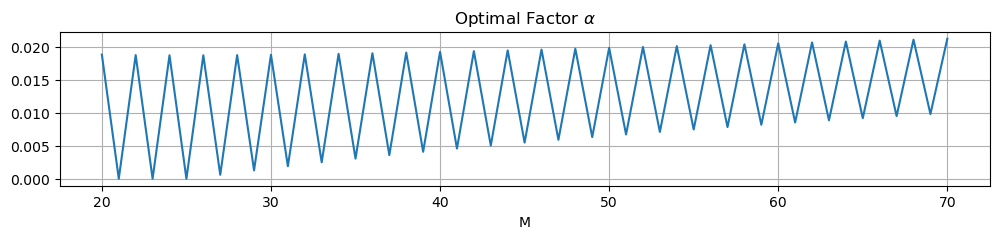

In [59]:
plt.figure(figsize=(12, 2))
plt.plot(Rev_Err_Val_p['M'], Opt_Val_p["Opt. Factor"])

plt.xlabel('M')
plt.ylabel('')
plt.title(r'Optimal Factor $\alpha$')
plt.grid(True)

plt.show()

As we see so far, prices for put options have followed the same pattern as those of call options, as expected. Our next task is to try and obtain a formula of $\alpha$ as a function of $M$, but as the plot above illustrate, we will need to separate the odd from the even $M$s. As mentioned, we will focus on the odd $M$s for this put option consideration.

In [60]:
Opt_Val_p_even = pd.DataFrame([x for x in Opt_Val_p.to_dict('records') if int(x['M']) in even])
Opt_Val_p_odd = pd.DataFrame([x for x in Opt_Val_p.to_dict('records') if int(x['M']) in odd])

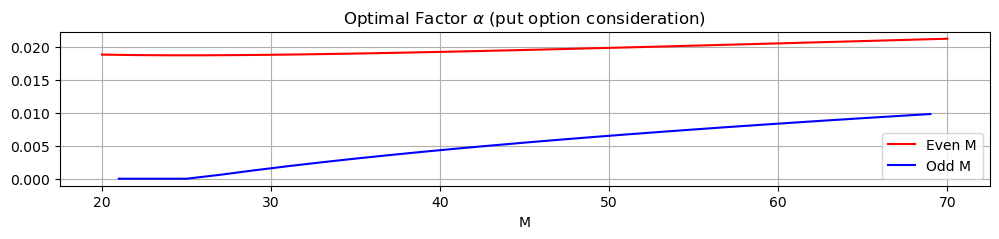

In [61]:
plt.figure(figsize=(12, 2))

plt.plot(Opt_Val_p_even['M'], Opt_Val_p_even["Opt. Factor"], color='red', label='Even M')
plt.plot(Opt_Val_p_odd['M'], Opt_Val_p_odd["Opt. Factor"], color='blue', label='Odd M')

plt.xlabel('M')
plt.ylabel('')
plt.title(r'Optimal Factor $\alpha$ (put option consideration)')
plt.legend()
plt.grid(True)

plt.show()

It is reasonable to surmise that, as in the case of call options, a quadratic approximation would be better than linear.

In [62]:
## Training a quadratic regression model.

X = Opt_Val_p_odd['M']
y = Opt_Val_p_odd['Opt. Factor']

X_squared = X**2
X = pd.DataFrame({'M': X, 'M_squared': X_squared})
X = sm.add_constant(X)

# Fit the quadratic regression model
model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

intercept = results.params['const']
slope = results.params['M']
quadratic_term = results.params['M_squared']

print(f"Intercept: {intercept}")
print(f"Slope (M): {slope}")
print(f"Quadratic Term (M^2): {quadratic_term}")

                            OLS Regression Results                            
Dep. Variable:            Opt. Factor   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     2890.
Date:                Thu, 20 Mar 2025   Prob (F-statistic):           2.33e-27
Time:                        20:48:53   Log-Likelihood:                 177.87
No. Observations:                  25   AIC:                            -349.7
Df Residuals:                      22   BIC:                            -346.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0074      0.000    -16.990      0.0

In [63]:
quad_adj_price_coll = []
for m in range(0, 51):
    M = m+20
    ctr = center_coll["Center"][m]
    adj_price = adj_put_price(quad_predict_opt_factor(M))
    quad_adj_price_coll.append({
        "M": int(M),
        "Adjusted Price (Put)": (adj_price)
    })

quad_adj_price_coll = pd.DataFrame(quad_adj_price_coll)

In [64]:
quad_alpha_coll = []
for m in range(0, 51):
    M = m+20
    ctr = center_coll["Center"][m]
    alpha = quad_predict_opt_factor(M)
    quad_alpha_coll.append({
        "M": int(M),
        r"$\alpha$": float(alpha)
    })

quad_alpha_coll = pd.DataFrame(quad_alpha_coll)
quad_alpha_coll.T

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
M,20.00000,21.00000,22.000000,23.00000,24.000000,25.000000,26.000000,27.000000,28.000000,29.000000,...,61.000000,62.000000,63.00000,64.000000,65.000000,66.000000,67.000000,68.000000,69.000000,70.000000
$\alpha$,-0.00098,-0.00069,-0.000404,-0.00012,0.000161,0.000439,0.000714,0.000986,0.001256,0.001523,...,0.008575,0.008749,0.00892,0.009088,0.009253,0.009416,0.009576,0.009733,0.009887,0.010039


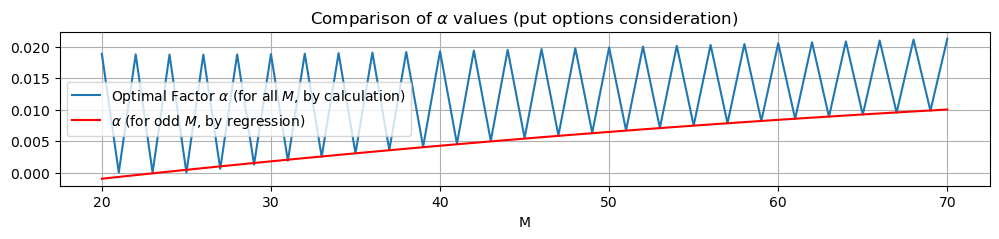

In [65]:
plt.figure(figsize=(12, 2))

plt.plot(Rev_Err_Val_p['M'], Opt_Val_p["Opt. Factor"], label=r'Optimal Factor $\alpha$ (for all $M$, by calculation)')

plt.plot(quad_alpha_coll['M'], quad_alpha_coll[r"$\alpha$"], color='red', label=r'$\alpha$ (for odd $M$, by regression)')

plt.xlabel('M')
plt.ylabel('')
plt.title(r'Comparison of $\alpha$ values (put options consideration)')  # More descriptive title
plt.grid(True)
plt.legend()
plt.show()

In [66]:
quad_adj_price_coll_odd = pd.DataFrame([x for x in quad_adj_price_coll.to_dict('records') if int(x['M']) in odd])
quad_adj_price_coll_odd.T

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
M,21.000000,23.000000,25.000000,27.000000,29.000000,31.000000,33.000000,35.000000,37.000000,39.000000,...,51.000000,53.000000,55.00000,57.000000,59.000000,61.000000,63.000000,65.000000,67.00000,69.000000
Adjusted Price (Put),3.374459,3.373115,3.372126,3.371397,3.370862,3.370474,3.370197,3.370006,3.369879,3.369802,...,3.369856,3.369898,3.36994,3.369979,3.370014,3.370044,3.370067,3.370083,3.37009,3.370088


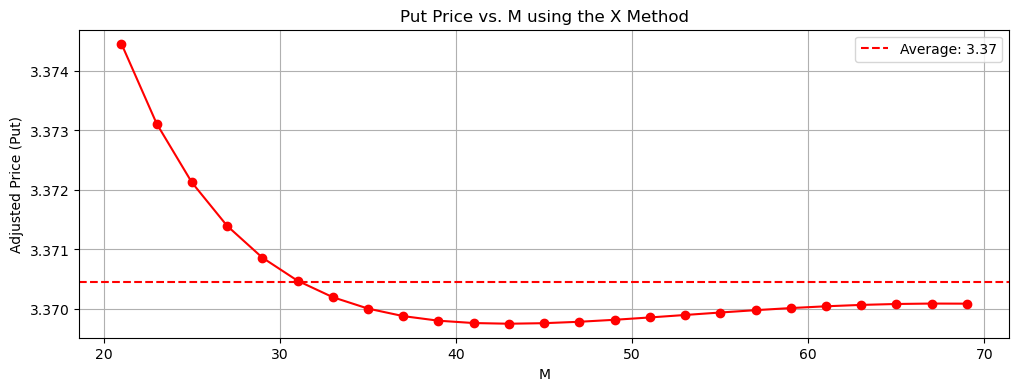

In [67]:
plt.figure(figsize=(12, 4))

put_odd_X = np.mean(quad_adj_price_coll_odd['Adjusted Price (Put)'])
plt.axhline(y=put_odd_X, color='red', linestyle='--', label=f'Average: {put_odd_X:.2f}')

plt.plot(quad_adj_price_coll_odd['M'], quad_adj_price_coll_odd['Adjusted Price (Put)'], marker='o', color="red", linestyle='-')

plt.xlabel('M')
plt.ylabel('Adjusted Price (Put)')
plt.title('Put Price vs. M using the X Method')
plt.legend()
plt.grid(True)

plt.show()

As we can see from this plot, within the range of $M$ that we consider, the put price do not differ from the benchmark Black-Scholes price for more than 0.004 or 0.005, just as it was the case with call option prices for even $M$s.

## Summary

Let's now summarize the results.

In [68]:
print(f"Call price using Black-Scholes: {bs_price['Binomial Call'][9]:.2f}")
print(f"Put price using Black-Scholes: {bs_price['Binomial Put'][9]:.2f}\n")
print('Prices using the X Method using Quadratic Regression for alpha (averaged):')
print(f'Call Price: {call_even_X:.2f}')
print(f'Put Price: {put_odd_X:.2f}')

Call price using Black-Scholes: 4.61
Put price using Black-Scholes: 3.37

Prices using the X Method using Quadratic Regression for alpha (averaged):
Call Price: 4.61
Put Price: 3.37


The average prices for the call and put options are, in fact, exactly equal to the benchmark Black-Scholes prices within the range of $M$ that we consider. Thus, quadratic regressions for the X Method works well to estimate $\alpha$ for the kernel fattening of the tails of the binomial distribution for these $M$s. It would also be good to test if the quadratic regressions work outside the range of $M$ that we have considered - since that is the purpose of it - but judging from the fact that the fitting works extremely well within the range of $M$ for which the regressions are trained, we surmise that the quadratic regressions will work well for a reasonable extension of the range of the $M$s used for the training. Thus, the quadratic regressions may be used to generate a certain number $n$ of $\alpha$s, $\{\alpha_1, \alpha_2, \alpha_3, \ldots, \alpha_n\}$, generate the binomial distributions of these $n$ numbers, apply $K_{\alpha_i}(r)$ for these $n$ distributions, and out come the option prices, after which the average can be obtained for more stability and accuracy.

For further explorations, one may want to see how well the X Method works for other parameter values, especially for OTM or ITM options. There is no foreseeable discrepancies and the method should work equally well, but it is worth exploring numerically, too. Finally, the most important direction to explore is how we can use historical data to calibrate the $\alpha$s for extrapolation purposes.

## Appendix

In this appendix, we derive the number $r$ of "success" trials (the number $r$ of "ups" to be precise) where the tails are fatter. Recall from above (Eq. (2)) that the kernel is given by
\begin{equation*}
K_\alpha(r)=\alpha\left\lvert\frac{8.2}{N}r-4.1\right\rvert+0.9,
\end{equation*}
where $N$ is the number of “Bernoulli trials,” $r\in\{0, 1, 2, \ldots , N\}$, and $\alpha$ is the parameter to be tuned for a “proper” fattening. $K_\alpha(r)$ is the proportion of the original frequency corresponding to $r$, which serves as the ``adjusted" frequencies. Thus, to compute the $r$s where the frequencies are increased, we simply compute the $r$s that satisfy $K_\alpha(r)>1$. Simple algebra leads to
\begin{equation*}
r>\frac{N}{8.2}\left(\frac{0.1+4.1\alpha}{\alpha}\right)
\end{equation*}
or
\begin{equation*}
r<\frac{N}{8.2}\left(\frac{4.1\alpha-0.1}{\alpha}\right).
\end{equation*}

Let's use these criteria to compute the $r$ for $N=20$ using the $\alpha$ corresponding to the associated call option. Thus, we have
\begin{equation*}
r>\frac{20}{8.2}\left(\frac{0.1+4.1(0.181483)}{0.181483}\right)\approx 11.34
\end{equation*}
or
\begin{equation*}
r<\frac{20}{8.2}\left(\frac{4.1(0.181483)-0.1}{0.181483}\right)\approx 8.66.
\end{equation*}
These results are reflected by the associated distribution above.

We also have a distribution for when $N=50$ above, also using the $\alpha$ corresponding to the associated call option. The demonstration is left to the reader to perform.